## Mini PJT

- 쇼핑몰 사용자 고객 세분화
- 데이터를 고객 단위로 묶고, 정제하여 월별/고객별 재정렬하기 (aggregation)
- 고객 유형 세분화, 즉 클러스터링하기

### Data Description

Source : https://www.kaggle.com/c/instacart-market-basket-analysis

### 1. 데이터 불러오기 

In [67]:
# instacart 데이터를 모두 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
prior = pd.read_csv('order_products__prior.csv')
train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

In [68]:
print(aisles.shape, departments.shape, prior.shape, train.shape, orders.shape, products.shape)

(134, 2) (21, 2) (32434489, 4) (1384617, 4) (3421083, 7) (49688, 4)


In [69]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [70]:
len(aisles['aisle'].unique())

134

In [71]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [72]:
len(departments['department'].unique())

21

In [73]:
prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [74]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [75]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [76]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [77]:
len(products['product_name'].unique())

49688

- 지금 분석의 목표는 고객을 유형별로 묶는 것이다
- 따라서 row는 user를 기준으로 해야 하며 이는 orders의 user_id를 활용할 수 있다
- 만약 고객을 product별로 패턴을 찾는다면, product 49688개에 대해 feature가 생긴다.
    - 예를 들어 Chocolate Sandwich Cookies라는 feature를 고객별로 몇개 샀는지가 한 컬럼에 해당된다

In [78]:
# prior가 매우 크기 때문에 10000개만 slicing 한다.
prior_sample = prior[:10000]
prior_sample

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
9995,1022,21903,1,1
9996,1022,38689,2,1
9997,1022,30391,3,1
9998,1022,18670,4,1


In [79]:
# 불러온 모든 테이블을 합치기
temp = pd.merge(orders, prior_sample, on='order_id')     # order_id에 대해 inner join
temp = pd.merge(temp, products, on='product_id')
temp = pd.merge(temp, aisles, on='aisle_id')
temp = pd.merge(temp, departments, on='department_id')
temp

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,40,382,prior,29,1,15,23.0,10070,1,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
1,235,58701,prior,20,5,9,9.0,10070,7,1,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
2,581,76141,prior,3,6,17,7.0,10070,3,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
3,649,135836,prior,1,4,7,NaN,10070,1,0,Organic 1% Low Fat Milk,84,16,milk,dairy eggs
4,40,382,prior,29,1,15,23.0,34866,4,1,Chocolate Milk 1% Milkfat,84,16,milk,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,152,103040,prior,12,1,10,7.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9996,959,119941,prior,2,6,13,21.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9997,400,180454,prior,32,0,8,8.0,5161,3,1,Dried Mango,18,10,bulk dried fruits vegetables,bulk
9998,18,118860,prior,3,4,20,6.0,1000,3,0,Apricots,18,10,bulk dried fruits vegetables,bulk


- merge의 how의 defalut는 inner join이다

### 2. 데이터 살펴보기 (EDA)

In [80]:
# 10만개의 거래내역에 대해서 각 물품을 얼마나 샀을까?
temp.user_id.value_counts()     # 972명    # ex. 149156 user는 46개의 product를 주문했다

149156    46
150739    45
11335     44
119437    39
87889     38
          ..
36916      1
99415      1
160167     1
15161      1
154766     1
Name: user_id, Length: 972, dtype: int64

In [81]:
temp.order_id.value_counts()   # 977건

775    46
742    45
454    44
970    39
315    38
       ..
802     1
534     1
985     1
796     1
202     1
Name: order_id, Length: 977, dtype: int64

In [82]:
temp.product_id.value_counts()      # 4511개의 물품  # ex. 24852 product는 156개가 팔렸다

24852    156
13176    119
21137     73
21903     70
47209     68
        ... 
31073      1
26882      1
18434      1
40216      1
10915      1
Name: product_id, Length: 4511, dtype: int64

In [83]:
temp.groupby(['user_id', 'order_id', 'product_id'])['aisle'].count()

user_id  order_id  product_id
382      40        10070         1
                   33198         1
                   34866         1
                   42450         1
503      214       5499          1
                                ..
205970   3         21903         1
                   24838         1
                   32665         1
                   33754         1
                   46667         1
Name: aisle, Length: 10000, dtype: int64

- PRIMARY KEY는 (user_id, order_id, product_id) 이다

In [84]:
temp.order_hour_of_day.value_counts().sort_index()

0      76
1      26
2       5
4      16
6      95
7     231
8     601
9     818
10    813
11    793
12    903
13    821
14    706
15    775
16    815
17    771
18    546
19    335
20    373
21    172
22    175
23    134
Name: order_hour_of_day, dtype: int64

<Axes: xlabel='order_hour_of_day', ylabel='count'>

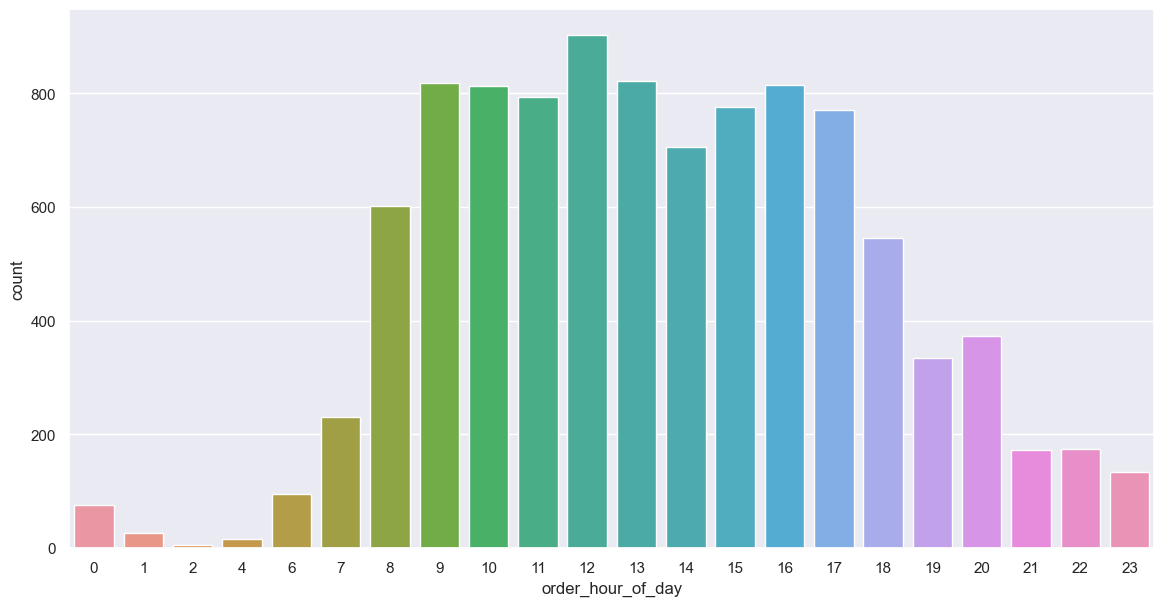

In [89]:
sns.set_style('darkgrid')
plt.figure(figsize=(14, 7))
sns.countplot(x='order_hour_of_day', data=temp)

- 12시를 기준으로 bell-shape 분포를 지닌다

In [90]:
temp.keys()

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'aisle', 'department'],
      dtype='object')

In [93]:
temp.product_name.value_counts()

Banana                               156
Bag of Organic Bananas               119
Organic Strawberries                  73
Organic Baby Spinach                  70
Organic Hass Avocado                  68
                                    ... 
Organic Bunch Arugula                  1
Russet Potatoes                        1
Organic Whole Crimini Mushrooms        1
Yukon Gold Potatoes                    1
Organic Short Brown Sprouted Rice      1
Name: product_name, Length: 4511, dtype: int64

- 신선식품(banana, strawberries, avocado 등)이 높은 판매율을 보인다

In [107]:
top10_product=pd.DataFrame(temp.product_name.value_counts()[:10])
top10_product

,product_name
Banana,156
Bag of Organic Bananas,119
Organic Strawberries,73
Organic Baby Spinach,70
Organic Hass Avocado,68
Organic Avocado,53
Strawberries,52
Large Lemon,46
Organic Yellow Onion,41
Organic Raspberries,39


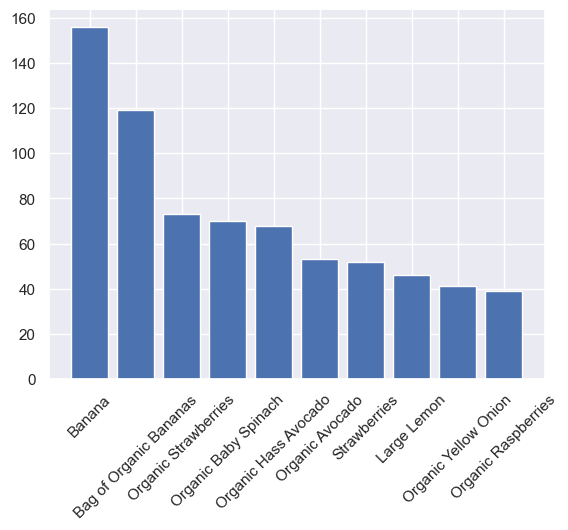

In [111]:
plt.bar(top10_product.index, top10_product['product_name'])
plt.xticks(rotation=45)
plt.show()

- 판매율 Top10 제품들을 보면, 대부분 신선제품이다
- 특히 banana, strawberries, avocado, lemon 등 fruits가 많다

In [94]:
temp.department.value_counts()

produce            2913
dairy eggs         1647
snacks              862
beverages           801
frozen              746
pantry              598
canned goods        362
bakery              354
deli                319
dry goods pasta     255
household           249
breakfast           238
meat seafood        225
babies              131
personal care       125
international        86
pets                 28
alcohol              27
missing              15
other                13
bulk                  6
Name: department, dtype: int64

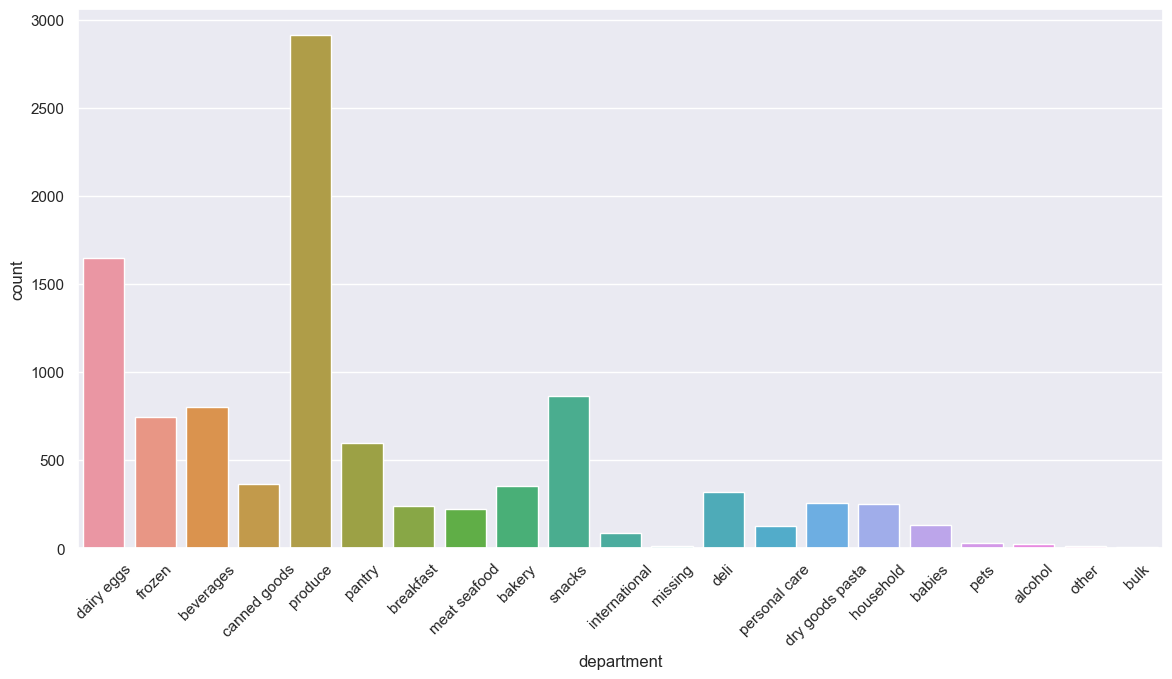

In [98]:
plt.figure(figsize=(14, 7))
sns.countplot(x='department', data=temp)
plt.xticks(rotation=45)
plt.show()

- produce 매대의 상품이 가장 높은 판매율을 보인다
- produce에는 어떤 상품을 파는지 확인해보자

In [100]:
temp[temp['department']=='produce']['product_name'].value_counts()

Banana                           156
Bag of Organic Bananas           119
Organic Strawberries              73
Organic Baby Spinach              70
Organic Hass Avocado              68
                                ... 
Red Onions                         1
Jack Habanero Cheese               1
Sweet Potato (Yam)                 1
Organic Sunchoke                   1
Mini Seedless Watermelon Pack      1
Name: product_name, Length: 504, dtype: int64

- 앞서 본 판매율 상위에 랭크한 제품들이 모두 produce 매대에 배치되어 있다

In [103]:
temp.aisle.value_counts()

fresh fruits                    1128
fresh vegetables                1076
packaged vegetables fruits       514
yogurt                           395
packaged cheese                  313
                                ... 
first aid                          2
beauty                             1
eye ear care                       1
skin care                          1
bulk grains rice dried goods       1
Name: aisle, Length: 133, dtype: int64

- 역시나 신선 제품 section이 가장 높은 판매율을 보인다

### 3. 데이터 전처리
- 데이터를 user 단위로 변경하여 user당 정보로 변환하자
    - User 단위로 어떤 물품을 구매했는지의 정보만 가지는 feature vector로 변환한다.
    - e.g. pd.crosstab, CountVectorizer

In [115]:
# transaction(user-level) 단위로 변경하고, User당 정보로 변환하는 과정까지 마무리한다

# 어떤 feature를 선택할까? - deparment, aisle, product_name
# aisle과 product_name은 고차원으로 차원의 저주가 우려되므로 department를 선택한다

X = pd.crosstab(index=temp.user_id, columns=temp.department)
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


- user(row)에 따른 제품별 구매 수량(column)

### 4. 클러스터링 모델 적용하기

- KMeans로 클러스터링 모델 적용하기
- Elbow method를 이용해 최적의 k값을 찾기
- 클러스터링 결과는 시각화 후, 실루엣 지수 계산하기

In [114]:
# data setting
X

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,...,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
382,0,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,1,0,2,1,0,0,...,0,0,1,0,0,1,0,0,2,0
971,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1059,0,0,3,0,3,0,0,8,0,0,...,0,1,2,0,0,2,0,0,8,2
1177,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204184,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
204484,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,4,1
204912,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,1,0


In [116]:
# tSNE : 시각화 용도의 차원감소 기법. (2차원으로 변환해주는 기법)
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_data = tsne.fit_transform(X)
tsne_data

array([[-21.934208 ,  14.1142   ],
       [-12.006828 ,   5.395503 ],
       [-22.166946 ,   3.1440492],
       ...,
       [ -8.513771 ,  13.461968 ],
       [-21.256176 ,  16.76861  ],
       [ 12.371204 ,   8.246567 ]], dtype=float32)

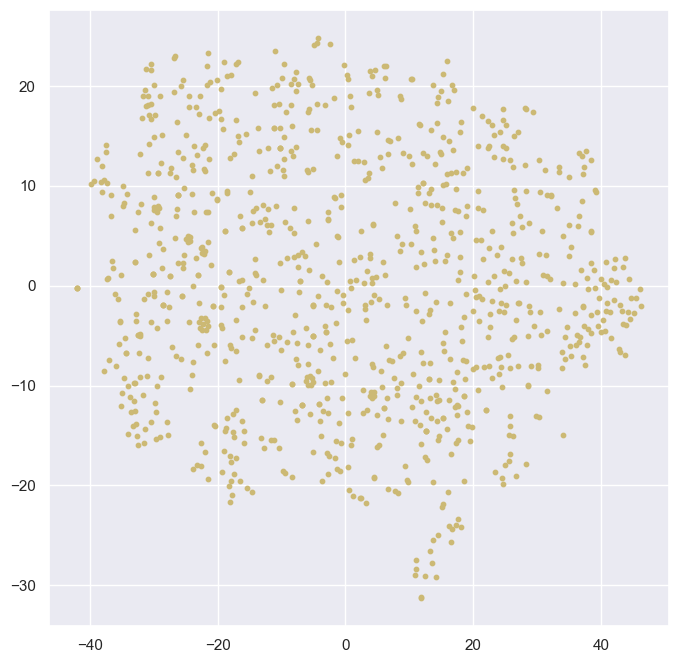

In [117]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c='y')
plt.show()

In [119]:
# Loading packages
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

# Kmeans를 돌려본다
model = KMeans(n_clusters=4)    # 4개의 cluster 생성
pred = model.fit_predict(X)     # fit_predict: fit과 predict 모두 작동   # unsupervised이므로 fit_predict 한번에
pred

C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


array([0, 0, 0, 1, 0, 3, 1, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 3, 0, 3, 0,
       0, 0, 3, 3, 0, 3, 0, 0, 0, 3, 0, 1, 1, 2, 0, 1, 0, 1, 3, 0, 3, 3,
       0, 0, 3, 0, 0, 3, 0, 0, 3, 0, 3, 3, 3, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       3, 0, 3, 0, 1, 0, 0, 0, 1, 3, 0, 2, 0, 3, 2, 0, 0, 3, 0, 3, 3, 1,
       0, 0, 0, 3, 2, 3, 0, 0, 0, 0, 3, 0, 3, 0, 1, 0, 3, 0, 0, 0, 0, 3,
       0, 0, 0, 3, 0, 3, 0, 2, 0, 3, 0, 2, 3, 1, 0, 0, 3, 0, 3, 0, 3, 0,
       0, 3, 0, 0, 3, 3, 0, 0, 3, 0, 3, 3, 3, 1, 0, 1, 3, 3, 3, 1, 0, 2,
       0, 2, 0, 3, 3, 0, 0, 3, 0, 3, 0, 0, 3, 2, 3, 3, 0, 3, 1, 3, 1, 0,
       0, 3, 1, 0, 3, 0, 3, 0, 0, 2, 0, 2, 3, 0, 0, 0, 3, 0, 0, 3, 0, 2,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 0, 0,
       1, 3, 3, 3, 1, 3, 3, 3, 3, 0, 0, 2, 3, 0, 3, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 3, 3, 0, 0, 3, 0, 3, 0, 2, 1, 1, 0, 3, 0, 0, 0, 0, 0, 3, 1,
       0, 3, 1, 3, 0, 0, 0, 1, 0, 3, 3, 0, 0, 3, 0, 3, 0, 1, 0, 0, 3, 0,
       2, 0, 0, 1, 0, 0, 0, 0, 0, 2, 3, 1, 0, 0, 0,

In [120]:
print(f"Silhouette Score: {silhouette_score(X, pred)}")

Silhouette Score: 0.19101059461749603


- 1에 가까울 수록 클러스터링이 잘 된 것이다

In [125]:
# Best K 찾기: elbow method
sse = []
silhouettes = []

for K in range(2,21):
    model = KMeans(n_clusters=K)
    pred = model.fit_predict(X)
    sse.append(model.inertia_)    # SSE
    silhouettes.append(silhouette_score(X, pred))

C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Windows\System32\myenv\lib\site-packages\sklearn\

In [126]:
sse

[17102.231999999993,
 15113.189019436719,
 13802.273550328813,
 13049.79346942708,
 12456.89299568735,
 11903.602553180444,
 11438.39386022845,
 10927.876977794871,
 10574.548254145891,
 10285.563819312527,
 10014.505634577048,
 9777.016176581423,
 9634.600532862216,
 9228.000487182657,
 9118.565579634913,
 8928.87360007838,
 8776.923001002378,
 8582.437084618996,
 8534.393727739207]

In [127]:
silhouettes

[0.36410685626179695,
 0.219499478455661,
 0.19148368017762255,
 0.19375847380227154,
 0.18963196279608174,
 0.19024251179009735,
 0.12318134509944598,
 0.15676138717003996,
 0.16615151817068607,
 0.16343774613619041,
 0.10680081016153298,
 0.16757452073754778,
 0.1037363820925841,
 0.11308695314889187,
 0.10536344537387861,
 0.1100613426251414,
 0.10950675206779618,
 0.09242009664929955,
 0.10997434163374979]

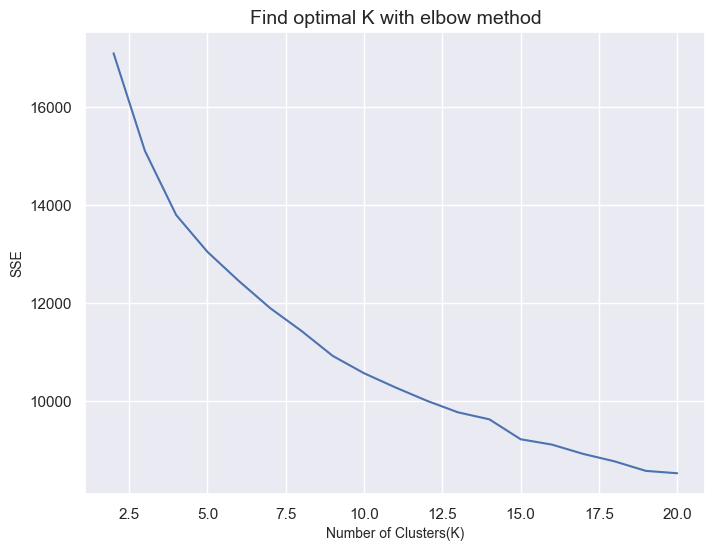

In [128]:
# K에 따른 SSE

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with elbow method", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("SSE", fontsize=10)
plt.plot(range(2, 21), sse)
plt.show()

- SSE가 가장 급격하게 꺾이는 구간이 Optimal K
- K=4쯤이 가장 급격하게 꺾인다

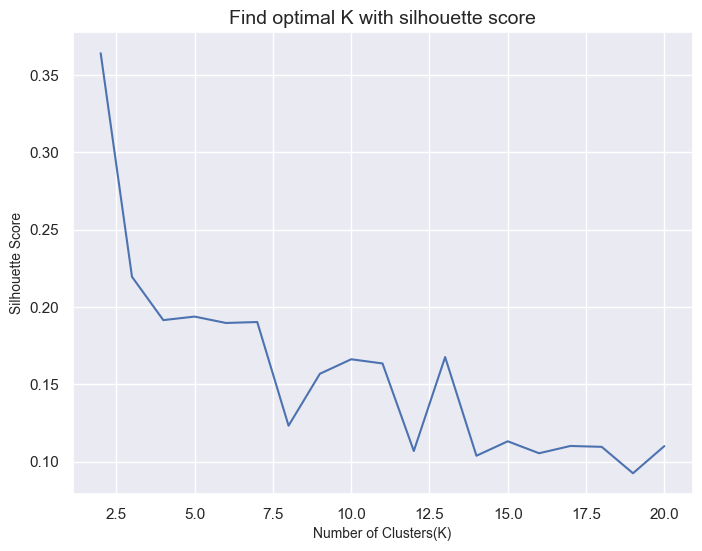

In [130]:
# K에 따른 Silhouette score

plt.figure(figsize=(8, 6))
plt.title("Find optimal K with silhouette score", fontsize=14)
plt.xlabel("Number of Clusters(K)", fontsize=10)
plt.ylabel("Silhouette Score", fontsize=10)
plt.plot(range(2, 21), silhouettes)
plt.show()

- cluter가 2일때 가장 높은 실루엣 점수를 보인다

In [133]:
# k=2, k=4에 대한 모델링 및 시각화
model2 = KMeans(n_clusters=2)    
pred2 = model2.fit_predict(X)

model4 = KMeans(n_clusters=4)    
pred4 = model4.fit_predict(X)

print(f"Silhouette Score(K=2): {silhouette_score(X, pred2)}")
print(f"Silhouette Score(K=4): {silhouette_score(X, pred4)}")

Silhouette Score(K=2): 0.36410685626179695
Silhouette Score(K=4): 0.19092700330178897


C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Windows\System32\myenv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


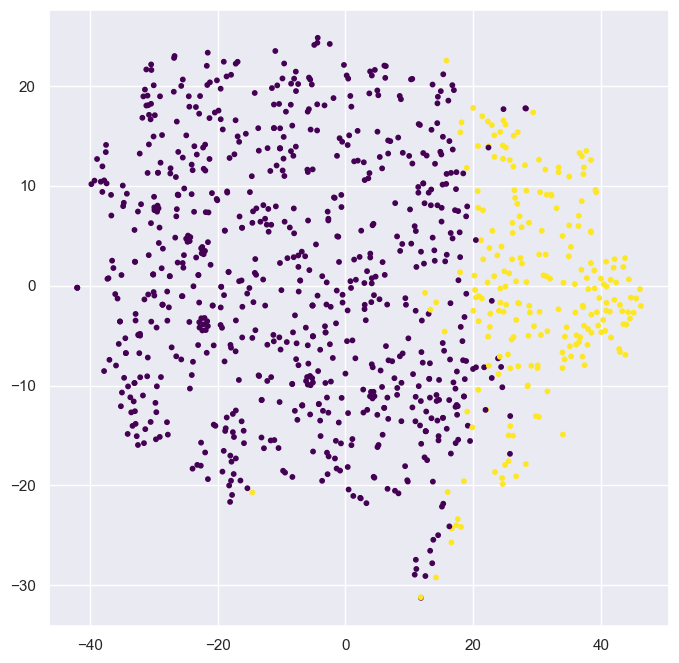

In [151]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred2, cmap="viridis")
plt.show()

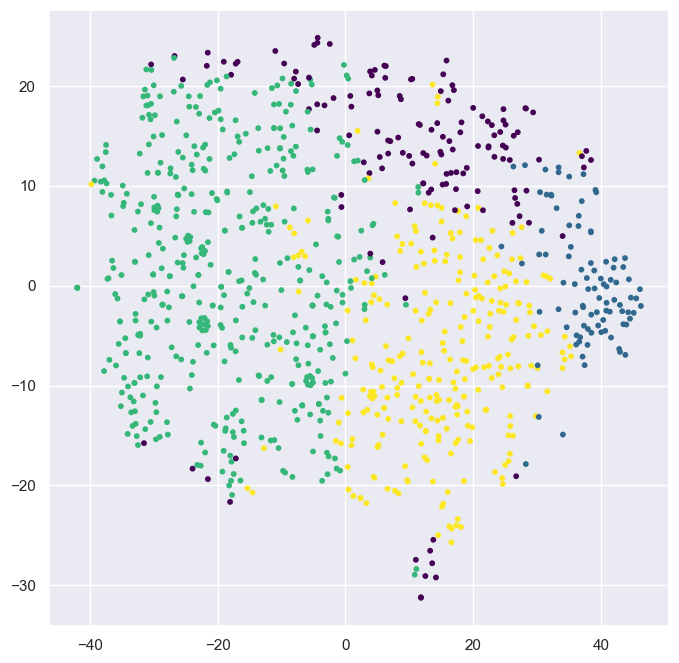

In [152]:
plt.figure(figsize=(8, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], s=10, c=pred4, cmap="viridis")
plt.show()

In [139]:
# see summary
X['cluster_label_2'] = pred2
group1 = X[X.cluster_label_2==0]
group2 = X[X.cluster_label_2==1]
group1.shape, group2.shape

((750, 22), (222, 22))

In [140]:
group1.mean()

department
alcohol            0.033333
babies             0.105333
bakery             0.297333
beverages          0.776000
breakfast          0.201333
bulk               0.002667
canned goods       0.282667
dairy eggs         1.273333
deli               0.241333
dry goods pasta    0.202667
frozen             0.653333
household          0.252000
international      0.073333
meat seafood       0.166667
missing            0.014667
other              0.016000
pantry             0.512000
personal care      0.129333
pets               0.026667
produce            1.668000
snacks             0.728000
cluster_label_2    0.000000
dtype: float64

In [141]:
group2.mean()

department
alcohol            0.009009
babies             0.234234
bakery             0.590090
beverages          0.986486
breakfast          0.391892
bulk               0.018018
canned goods       0.675676
dairy eggs         3.117117
deli               0.621622
dry goods pasta    0.463964
frozen             1.153153
household          0.270270
international      0.139640
meat seafood       0.450450
missing            0.018018
other              0.004505
pantry             0.963964
personal care      0.126126
pets               0.036036
produce            7.486486
snacks             1.423423
cluster_label_2    1.000000
dtype: float64

- group 2는 produce를 주로 구매한 고객, group1은 그렇지 않은 고객

In [143]:
X['cluster_label_4'] = pred4
group1 = X[X.cluster_label_4==0]
group2 = X[X.cluster_label_4==1]
group3 = X[X.cluster_label_4==2]
group4 = X[X.cluster_label_4==3]
group1.shape, group2.shape, group3.shape, group4.shape

((143, 23), (92, 23), (461, 23), (276, 23))

In [144]:
group1.mean()

department
alcohol            0.006993
babies             0.300699
bakery             0.636364
beverages          1.118881
breakfast          0.468531
bulk               0.000000
canned goods       0.489510
dairy eggs         4.349650
deli               0.384615
dry goods pasta    0.580420
frozen             1.538462
household          0.272727
international      0.160839
meat seafood       0.398601
missing            0.041958
other              0.006993
pantry             1.013986
personal care      0.258741
pets               0.048951
produce            2.615385
snacks             1.825175
cluster_label_2    0.279720
cluster_label_4    0.000000
dtype: float64

- diary eggs > produce

In [145]:
group2.mean()

department
alcohol             0.010870
babies              0.239130
bakery              0.630435
beverages           1.336957
breakfast           0.347826
bulk                0.032609
canned goods        0.728261
dairy eggs          3.336957
deli                0.869565
dry goods pasta     0.467391
frozen              1.369565
household           0.358696
international       0.152174
meat seafood        0.369565
missing             0.010870
other               0.000000
pantry              1.000000
personal care       0.097826
pets                0.065217
produce            10.271739
snacks              1.554348
cluster_label_2     1.000000
cluster_label_4     1.000000
dtype: float64

- produce가 압도적으로 많다

In [146]:
group3.mean()

department
alcohol            0.043384
babies             0.086768
bakery             0.223427
beverages          0.767896
breakfast          0.175705
bulk               0.002169
canned goods       0.225597
dairy eggs         0.835141
deli               0.197397
dry goods pasta    0.149675
frozen             0.535792
household          0.264642
international      0.056399
meat seafood       0.125813
missing            0.006508
other              0.019523
pantry             0.427332
personal care      0.121475
pets               0.023861
produce            0.809111
snacks             0.594360
cluster_label_2    0.000000
cluster_label_4    2.000000
dtype: float64

- 이 외 고객들

In [147]:
group4.mean()

department
alcohol            0.018116
babies             0.094203
bakery             0.369565
beverages          0.594203
breakfast          0.210145
bulk               0.007246
canned goods       0.438406
dairy eggs         1.206522
deli               0.336957
dry goods pasta    0.217391
frozen             0.554348
household          0.199275
international      0.083333
meat seafood       0.275362
missing            0.018116
other              0.010870
pantry             0.594203
personal care      0.083333
pets               0.014493
produce            4.423913
snacks             0.666667
cluster_label_2    0.326087
cluster_label_4    3.000000
dtype: float64

- produce > diary eggs